In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random
import cv2
import os
import imageio

from IPython.display import display
from google.colab.patches import cv2_imshow
from PIL import Image
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential           # Functional API 사용 예정.
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D            # Layers.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
warnings.filterwarnings('ignore')                    # Turn the warnings off.
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# VGG16을 내려 받는다.
# 입력 크기는 224 이어야 한다.
my_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
my_vgg.trainable = False                # 축가 학습은 불가능한 상태이다.

In [ ]:
# 더 좋은 결과를 위해서 내려받은 모델에서 MaxPooling2D층을 AveragePooling2D로 교체한다.
# MaxPooling2D나 AveragePooling2D는 학습 파라미터가 없는 층이므로 교체가 용이하다!
my_vgg_new = Sequential()
for a_layer in my_vgg.layers:
    if a_layer.__class__ == MaxPooling2D:
        my_vgg_new.add(AveragePooling2D())
    else:
        my_vgg_new.add(a_layer)

In [ ]:
# Layer 구조를 출력해 본다.
my_layers = []
for a_layer in my_vgg_new.layers:
    my_layers.append(a_layer.name)
print(my_layers)

['block1_conv1', 'block1_conv2', 'average_pooling2d', 'block2_conv1', 'block2_conv2', 'average_pooling2d_1', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'average_pooling2d_2', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'average_pooling2d_3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'average_pooling2d_4']


In [ ]:
# 가져온 모델의 summary (내부 구조) 출력.
#my_vgg_new.summary()

In [ ]:
# Content layer와 Style layers를 정의한다.
my_content_layer = ['block3_conv1']
my_style_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [ ]:
# Functional API를 사용하여 모델을 만든다.
my_outputs = [ my_vgg_new.get_layer(a_layer).output for a_layer in my_content_layer + my_style_layers]
my_model = Model(inputs=[my_vgg_new.input], outputs=my_outputs )

In [ ]:
# 최종 모델의 summary (내부 구조) 출력.
#my_model.summary()

In [ ]:
# Style 이미지를 가져와서 resizing 해둔다.
img = Image.open(r"/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Program_folder/Picasso-The_Weeping_Woman.jpg")
#img = Image.open(r"../data/van_gogh.jpg")
X_raw = np.array(img)                          # Numpy 배열로 변환.
X_style = cv2.resize(X_raw,(224,224))        # BGR 또는 RGB channel 순서의 차이와 무관하게 리사이징이 가능하다.

In [ ]:
# Style 이미지의 행렬값 탐색.
print("MAX content value : {}".format(X_style.max()))
print("MIN content value : {}".format(X_style.min()))

MAX content value : 255
MIN content value : 0


array([[[175, 135,   6],
        [150, 113,   6],
        [132, 100,   6],
        ...,
        [200, 152,  13],
        [200, 153,  13],
        [201, 153,  12]],

       [[171, 130,   6],
        [141, 105,   3],
        [126,  95,   4],
        ...,
        [192, 149,  11],
        [192, 149,  10],
        [193, 150,  11]],

       [[168, 129,  10],
        [136, 102,   3],
        [124,  94,   7],
        ...,
        [193, 150,  11],
        [195, 151,  13],
        [194, 151,  12]],

       ...,

       [[ 27,  37,  45],
        [ 29,  39,  46],
        [ 29,  37,  50],
        ...,
        [ 37,  45,  56],
        [ 33,  43,  53],
        [ 28,  40,  50]],

       [[ 31,  38,  53],
        [ 39,  51,  40],
        [ 48,  61,  42],
        ...,
        [ 44,  53,  62],
        [ 33,  43,  53],
        [ 29,  37,  48]],

       [[ 29,  37,  48],
        [ 48,  58,  61],
        [ 43,  53,  53],
        ...,
        [ 35,  44,  53],
        [ 30,  40,  50],
        [ 29,  37,  48]]], dtype=uint8)
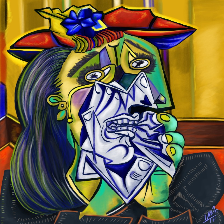

In [ ]:
X_style

In [ ]:
frame_folder = '/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Program_folder/frames'  # 프레임 폴더 경로 설정
frame_files = os.listdir(frame_folder)  # 프레임 폴더 내부 이미지 파일들 가져오기

In [ ]:
# X_original_0 ~ X_original_9 이미지 로드 및 처리
X_original_list = []
for i, file in enumerate(frame_files[:10]):
    # 이미지 파일 읽기
    img = Image.open(os.path.join(frame_folder, file))
    # 이미지를 NumPy 배열로 변환하고 0~1 사이의 값으로 스케일링
    X_raw = np.array(img) / 255.0
    # 이미지를 224x224 크기로 리사이징
    X_original = cv2.resize(X_raw, (224, 224))
    # X_original_0 ~ X_original_9에 추가
    X_original_list.append(X_original)

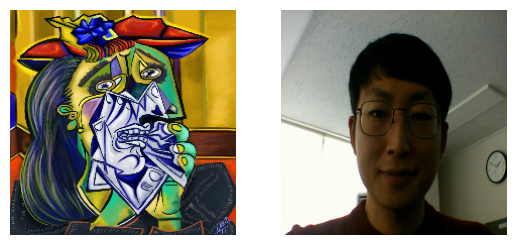

In [ ]:
# Style 이미지와 원본 이미지의 초기 상태 비교.
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_style)
axes[0].axis('off')
axes[1].imshow(X_original)
axes[1].axis('off')
plt.show()

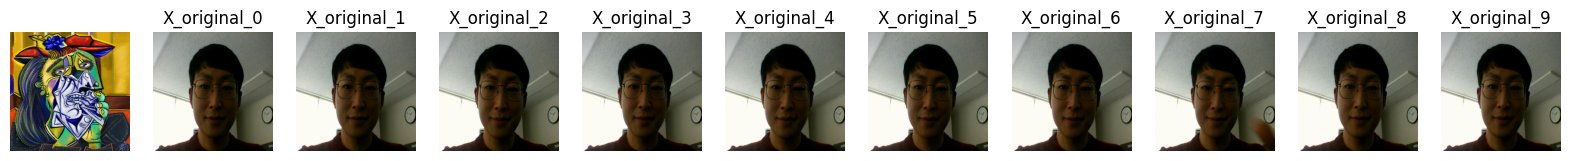

In [ ]:
# 저장된 이미지 피클 파일을 로드
#X_original_list = load_images_from_pickle_or(pickle_filename_or)

# X_original_0 ~ X_original_9 이미지 출력
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
axes[0].imshow(X_style)
axes[0].axis('off')
for i in range(10):
    axes[i+1].imshow(X_original_list[i])
    axes[i+1].axis('off')
    axes[i+1].set_title(f'X_original_{i}')
plt.show()

### 학습준비

In [ ]:
# Style 이미지의 출력은 딱 한번만 실행해 두면 된다!
my_outputs_style = my_model(preprocess_input(np.expand_dims(X_style,axis=0)))

In [ ]:
# X_original_list가 비어 있는지 확인
if len(X_original_list) < 2:
    print("에러: 이미지가 2개 미만")

In [ ]:
len(X_original_list)

10

In [ ]:
# X_original_list에서 처리한 10개의 이미지를 X_variables_list에 추가
X_variables_list = []
for X_original in X_original_list:
    # 이미지를 tf.Variable로 변환하여 X_variables_list에 추가
    X_variables_list.append(tf.Variable(X_original))

In [ ]:
len(X_variables_list)

10

In [ ]:
#  출력의 shape를 보여준다.
for i in range(len(my_outputs_style)):
    print(my_outputs_style[i].shape)

(1, 56, 56, 256)
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


In [ ]:
print("MAX array value : {:.3f}".format(X_original.max()))
print("MIN array value : {:.3f}".format(X_original.min()))

MAX array value : 1.000
MIN array value : 0.000


In [ ]:
# Gram 행렬을 계산해 주는 함수.
def gram(x):
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)             # b = batch이므로 그대로 둠. 사실상 c=d임. 동일한 크기 "HxWxC"의 행렬 (tensor)로 "CxC" Gram 행렬 계산!
    input_shape = x.shape
    denom = input_shape[1]*input_shape[2]                         # input_chape[1] = H, input_chape[2] = W. 그러므로 denom = HxW.
    return result/denom

In [ ]:
# 이미지 행렬의 값이 0~1을 벗어나면 clipping 해주는 함수.
def clip_0_1(x):
    return tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# VGG를 통과한 일종의 "예측값"을 계산해 주는 함수.
# 주의: preprocess_input 함수는 행렬의 원소가 0~255임을 전제한다.
#       그러므로 255를 곱해 주어야만 한다.
# Batch 학습을 하는 상황은 아니지만 batch에 해당하는 차원 (axis=0)을 확장시켜 주어야만 한다.
@tf.function
def predict():
    # 이미지를 전처리하고 연결
    preprocessed_images = preprocess_input(tf.concat([tf.expand_dims(img * 255, axis=0) for img in X_variables_list[:10]], axis=0))
    # 모델에 입력하여 예측 수행
    return my_model(preprocessed_images)


In [ ]:
cache ={}
@tf.function
def loss(y_pred, y):
    mse_content = tf.reduce_mean((y_pred[0] - y[0])**2)  # Content loss.

    if not "Gs" in cache:
        cache["Gs"] = [gram(y[i]) for i in range(1, 6)]  # Style 이미지의 Gram은 단 한번 계산해서 cache에 저장해 둔다.
    Gs = cache["Gs"]

    mse_style = 0
    for i in range(1, 6):
        if i == 1:
            mse_style += tf.reduce_mean((gram(y_pred[i]) - Gs[i-1])**2)  # 처음 계산.
        else:
            mse_style += tf.reduce_mean((gram(y_pred[i]) - Gs[i-1])**2)  # 누적.

    return mse_content + 0.001*mse_style


In [ ]:
# 하이퍼 파라미터를 설정해 준다.
n_epochs = 300                     # Number of epochs.
learn_rate = 0.005                  # learning rate.

In [ ]:
# 최적화 객체 생성.
my_optimizer = Adam(learning_rate=learn_rate)

In [ ]:
print(len(X_variables_list))

10


In [ ]:
# 원본
my_loss_history = []  # 손실을 기록해 주는 list.

# n번의 반복
for i_epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        # 이미지를 모델에 입력하여 예측 수행
        my_outputs = predict()

        # 손실 계산.
        my_loss = loss(my_outputs, my_outputs_style)

        # 손실을 기록
        if (i_epoch % 10 == 0):
            my_loss_history.append(my_loss.numpy())

    # 그래디언트 계산.
    gradients = tape.gradient(my_loss, X_variables_list[:10])

    # 그래디언트 적용.
    my_optimizer.apply_gradients(zip(gradients, X_variables_list[:10]))

    # Clipping 해준다.
    for i, var in enumerate(X_variables_list[:10]):
        X_variables_list[i].assign(clip_0_1(var))


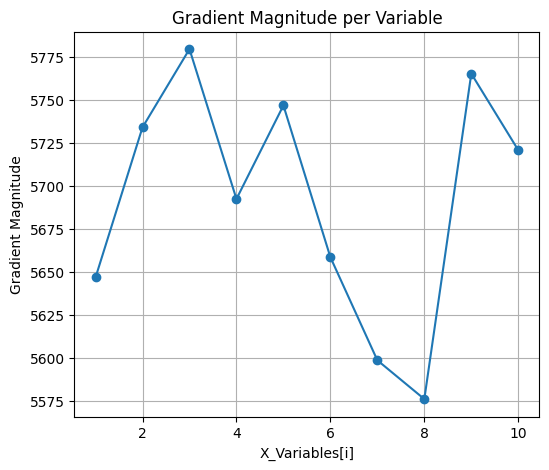

In [ ]:
with tf.GradientTape() as tape:
    my_outputs = predict()  # 모델의 예측값 계산
    my_loss = loss(my_outputs, my_outputs_style)  # 손실 계산

gradients = tape.gradient(my_loss, X_variables_list[:10])  # 그레디언트 계산

# 각 변수별 그레디언트 크기 계산
gradients_norm = [tf.norm(grad) for grad in gradients]

# 그레디언트 시각화
plt.figure(figsize=(6, 5))
plt.plot(range(1, len(gradients_norm) + 1), gradients_norm, marker='o', linestyle='-')
plt.xlabel('X_Variables[i]')
plt.ylabel('Gradient Magnitude')
plt.title('Gradient Magnitude per Variable')
plt.grid(True)
plt.show()

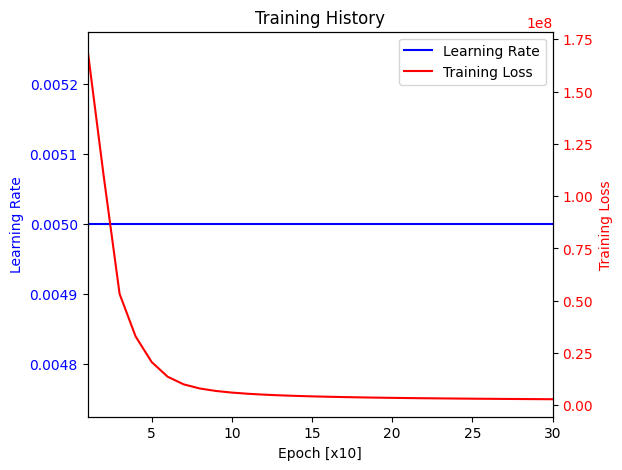

In [ ]:
# 에포크와 학습률 시각화
epochs = range(1, n_epochs+1)
learning_rates = [learn_rate] * n_epochs

fig, ax1 = plt.subplots(figsize=(6, 5))

# 학습률 그래프
ax1.plot(epochs, learning_rates, label='Learning Rate', color='blue')
ax1.set_xlabel('Epoch [x10]')
ax1.set_ylabel('Learning Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Training History')
ax1.set_xticks(range(0, 31, 5))  # x축 범위를 5 단위로 설정
ax1.set_xlim(1, 30)  # x축 범위를 1부터 30까지 설정

# 손실 그래프 그리기
ax2 = ax1.twinx()
ax2.plot(range(1, len(my_loss_history) + 1), my_loss_history, label='Training Loss', color='red')
ax2.set_ylabel('Training Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 학습률과 손실 범례를 따로 표시
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()


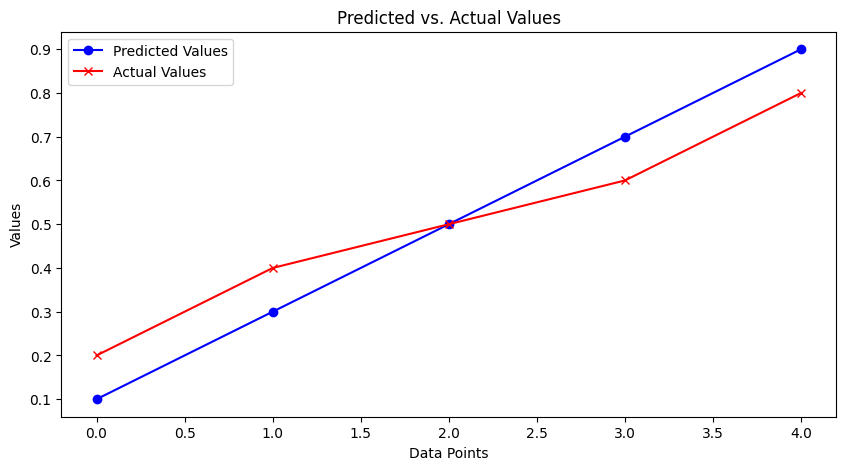

In [ ]:
# 예측값과 실제값
predicted_values = np.array([0.1, 0.3, 0.5, 0.7, 0.9])  # 모델의 예측값
actual_values = np.array([0.2, 0.4, 0.5, 0.6, 0.8])     # 실제값

# 데이터 포인트
x = np.arange(len(predicted_values))

plt.figure(figsize=(10, 5))

# 예측값과 실제값을 시각화
plt.plot(x, predicted_values, 'b', label='Predicted Values', marker='o')
plt.plot(x, actual_values, 'r', label='Actual Values', marker='x')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()

plt.show()


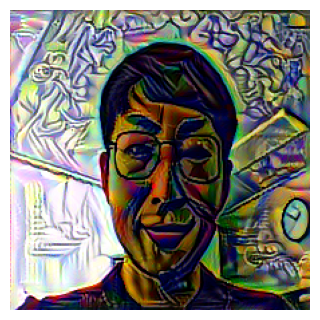

In [ ]:
# Style 전이가 된 이미지만을 조금 더 크게 출력해 본다.
fig = plt.figure(figsize=(3,3))
axes = fig.add_axes([0,0,1,1])
axes.imshow(X_variables_list[0].numpy())
axes.axis('off')
plt.show()

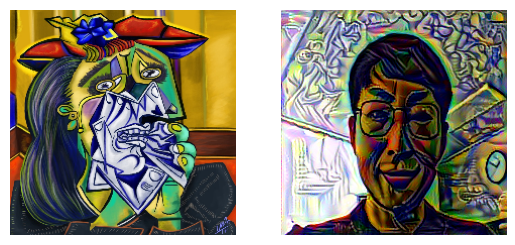

In [ ]:

# Style 이미지와 합성 이미지 비교.
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_style)
axes[0].axis('off')
axes[1].imshow(X_variables_list[0].numpy())
axes[1].axis('off')
plt.show()

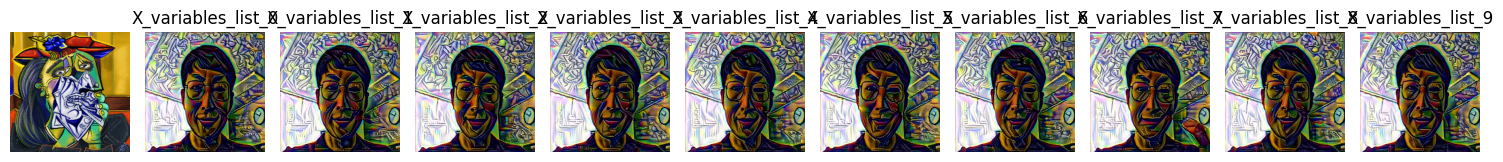

In [ ]:
# X_variables_list 출력
fig, axes = plt.subplots(1, len(X_variables_list) + 1, figsize=(15, 5))
axes[0].imshow(X_style)
axes[0].axis('off')

for i in range(len(X_variables_list)):
    axes[i+1].imshow(X_variables_list[i].numpy())
    axes[i+1].axis('off')
    axes[i+1].set_title(f'X_variables_list_{i}')
plt.tight_layout()
plt.show()

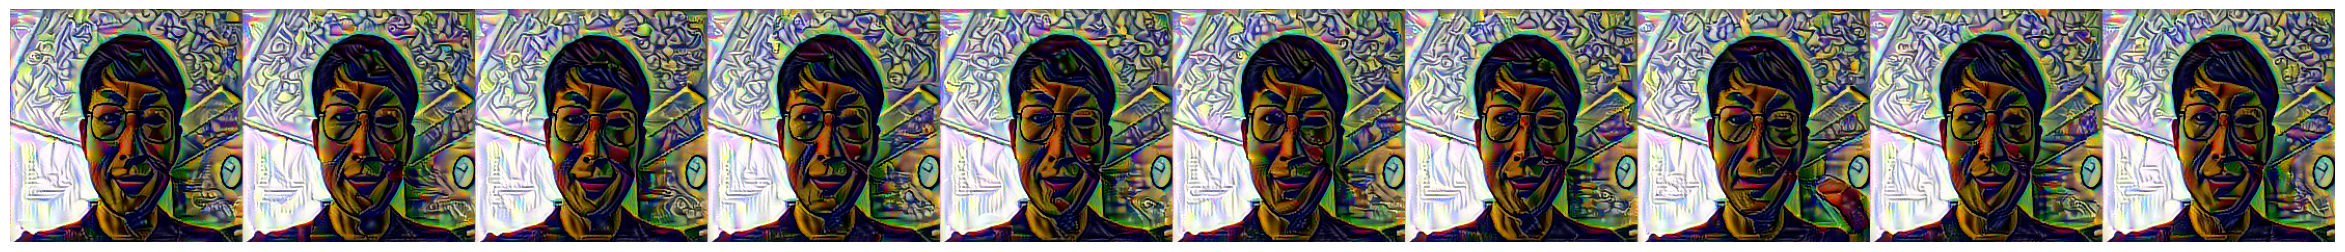

In [ ]:
# 전이 처리된 이미지를 가로로 결합
combined_image = tf.concat(X_variables_list, axis=1)

# 이미지 표시
plt.figure(figsize=(30, 5))
plt.imshow(combined_image.numpy())
plt.axis('off')
plt.show()

# 이미지 저장 경로 설정
save_path = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/transferred_images/"

# 전이 처리된 이미지를 따로따로 저장
for i, image in enumerate(X_variables_list[:]):
    # 이미지 경로 설정
    image_path = save_path + f"합성 이미지_{i}.png"

    # 이미지를 uint8 타입으로 변환 후 저장
    image_uint8 = tf.cast(image * 255.0, tf.uint8)
    tf.keras.preprocessing.image.save_img(image_path, image_uint8)

    print(f"합성이미지 {i} 저장 완료 : {image_path}")

### GIF 파일로 전환

In [ ]:
# PNG 파일이 있는 디렉토리 경로
png_folder = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Program_folder/transferred_images"

# GIF 파일의 경로와 이름
gif_filename = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Program_folder/Jay-won.gif"

# PNG 파일 목록 가져오기
png_files = [os.path.join(png_folder, file) for file in os.listdir(png_folder) if file.endswith('.png')]

# 프레임 파일들을 읽어들여서 GIF로 저장
frames = []
for file in png_files:
    frame = imageio.imread(file)  # 프레임 파일을 읽어서 이미지 배열로 변환
    frames.append(frame)

# frames를 이용하여 GIF 파일 생성
imageio.mimsave(gif_filename, frames, duration=0.2)  # duration은 각 프레임 간의 시간 간격을 결정합니다.

In [ ]:
from IPython.display import Image

# GIF 파일을 출력
Image(filename=gif_filename)